In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In this notebook, I will attempt to realise our plans with DKD from a meeting that we had on 17.10.2023. The plan is as following: 
1. Extract the height information from the metadata. This height is the unscaled optical thickness from the HoloMonitor images after being processed by HM beta app suite.
2. Multiply the optical thickness by a factor provided by HM to get the actual height in micrometers. The factor is 15.875. It comes from the following formula: 
<!-- $$ \text{conversion factor} = \frac{\text{wavelength_laser}}{\text{refractiveIndex_object} - \text{refractiveIndex_medium}} = \frac{0.635 \mu m}{1.38 - 1.34} $$ -->
$$ conversion factor = \frac{wavelength laser}{refractiveIndex object - refractiveIndex medium} = \frac{0.635 \mu m}{1.38 - 1.34} $$
3. Compute the minimum of each image - find the absolute minimum from the entire stackof images
4. Use the following formula to compute the height of the cell:
$$\hat{I}_{i,j} = \left(\frac{I_{i,j}}{\Delta I} \cdot \Delta \zeta_{i} + \zeta_{min} - \zeta_{i, min}\right) \cdot 1000 $$
Here, $\hat{I}_{i,j}$ is each transformed pixel for each image in the stack, $I_{i,j}$ is the original pixel value, $\Delta I$ is the difference between the maximum and minimum pixel values in the image (magic number 65535), $\Delta \zeta_{i}$ is the difference between the maximum and minimum optical thickness values for each image in the stack, $\zeta_{min}$ is the minimum pixel value in the stack, and $\zeta_{i, min}$ is the minimum optical thickness value in the image. The result is multiplied by 1000 to convert the units from micrometers to nanometers.
$$\Delta \zeta_{i} = \zeta_{i,max} - \zeta_{i, min}$$


Things for Future Nigar to do:
* figure out how to store velocity information of the cells 
* figure out how to sort the code for analysis
* transform the height information according to the formula above 


Future Nigar here. Yalla! Let's do this.

In [2]:
import os
import matplotlib.pyplot as plt  # plotting
import numpy as np  # numerics
from skimage import io
from natsort import natsorted
#import skimage.io
import skimage.color
import skimage.morphology
import skimage.measure as sm

from skimage.io import imread
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from skimage import (io, filters,  morphology, measure, segmentation, feature, util, exposure)
from scipy.ndimage import gaussian_filter 
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom

import csv


In [4]:
# Load multiple images. Example taken from https://scikit-image.org/docs/dev/user_guide/getting_started.html

plt.rcParams['figure.figsize'] = [10,10]

folder_path_B2_1 = './HM Beta TIFF/October 2023/MDCK 17.10.23/B2-1'

list_files = [os.path.join(folder_path_B2_1, f) for f in os.listdir(folder_path_B2_1)]
list_files = natsorted(list_files)
image_list_B2_1 = []

for filename in list_files:
    image_list_B2_1.append(io.imread(filename))

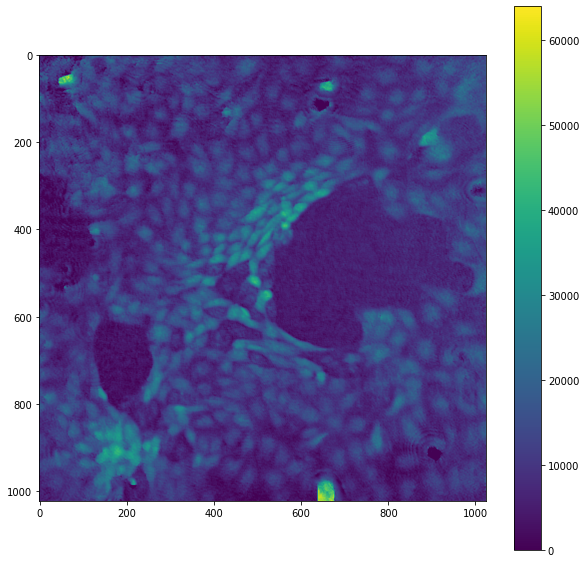

In [6]:
plt.imshow(image_list_B2_1[0]) #plotting the very first image here to see what it looks like
plt.colorbar()

In [36]:
#print pixel values of the first image
print(len(image_list_B2_1))
print(image_list_B2_1[0])
print(np.max(image_list_B2_1[0]))

241
[[11308 11308 11051 ... 17990 16962 15163]
 [11308 11051 10537 ... 18761 17476 15677]
 [11308 10537  9509 ... 17219 16191 15163]
 ...
 [ 5397  5140  5654 ...  6682  7453  8995]
 [ 5397  4626  5140 ...  5654  6425  7967]
 [ 5397  3855  4112 ...  4883  5397  6939]]
63993


In [43]:
print(image_list_B2_1[0].shape)
print(image_list_B2_1[0][0].shape)


(1024, 1024)
(1024,)


We basically have 3 dimensional data, where we have the x,y positions and the intensities as the third "dimension".

In [10]:
#read in minimum and maximum optical thickness values from csv file
#first column is minimum optical thickness, second column is maximum optical thickness
#first row is the first image, second row is the second image, etc.

# Define the file path
csv_file_path = 'max_min_values_rawHM.csv'

# Initialize empty lists to store the data
min_values = []
max_values = []

# Read the CSV file
with open(csv_file_path, 'r') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file)
    
    # Skip the header row if it exists
    header = next(csv_reader, None)
    
    # Iterate through the rows and extract data
    for row in csv_reader:
        # Assuming the data format is always as described
        min_values.append(float(row[0]))
        max_values.append(float(row[1]))

# Convert the lists to NumPy arrays
min_values_array = np.array(min_values, dtype=float)
max_values_array = np.array(max_values, dtype=float)

#multiply all values by HoloMonitor factor: 15.875
min_values_array = min_values_array*15.875
max_values_array = max_values_array*15.875

In [11]:
print(min_values_array)

[-2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2.00000076
 -2.00000076 -2.00000076 -2.00000076 -2.00000076 -2

In [12]:
print(max_values_array)

[17.3534705  18.0310155  13.64892495 11.20758014 11.43316389 14.7825587
 20.3838175  23.06234275 27.49357913 28.0336625  24.37914225 26.428192
 13.59163684 24.02251037 24.8012585  23.72636225 26.0811645  24.24676063
 27.71128887 13.43297415 13.9988671  13.99421414 27.32054163 16.35015462
 15.29913914 14.9961473  20.005929   17.85248525 14.75886367 15.32327708
 25.232487   15.54916721 19.36149925 14.29216408 15.20472099 14.44517526
 26.41388862 23.79437075 25.95668863 23.26470137 25.76833175 14.11925516
 18.20465625 15.56393731 15.902559   15.2308433  16.10917213 15.62365589
 18.13301237 15.1897969  19.25564475 18.91725325 16.92340087 18.2679975
 15.8438469  16.15898788 13.78601034 17.16797113 15.95283513 14.1567154
 16.54395662 22.90498975 23.4099735  26.44862313 27.62819912 15.09645507
 31.94156363 14.93339025 18.900648   15.28693444 15.91891025 15.02256171
 13.88164927 28.47743225 28.15580475 13.6194038  27.12597763 14.08571446
 13.936345   29.15153237 12.41878549 24.53330438 23.2007

In [13]:
zeta_min = np.min(min_values_array)
delta_zeta_i = abs(max_values_array - min_values_array) #should this be absolute value?
delta_I = 65535

Let's do this conversion for one image first, and see if the scaled pixel values make sense in terms of physical units and values: 

In [14]:
I_hat_0 = ( (image_list_B2_1[0]/delta_I) * delta_zeta_i[0] + zeta_min - min_values_array[0] ) * 1000 #scaled to nanometers for the first image in the stack

In [15]:
print(I_hat_0)

[[3339.42249235 3339.42249235 3263.52652662 ... 5312.71760147
  5009.13373853 4477.86197838]
 [3339.42249235 3263.52652662 3111.73459515 ... 5540.40549868
  5160.92567    4629.65390985]
 [3339.42249235 3111.73459515 2808.15073221 ... 5085.02970426
  4781.44584132 4477.86197838]
 ...
 [1593.81528044 1517.91931471 1669.71124618 ... 1973.29510912
  2200.98300632 2656.35880074]
 [1593.81528044 1366.12738324 1517.91931471 ... 1669.71124618
  1897.39914338 2352.77493779]
 [1593.81528044 1138.43948603 1214.33545176 ... 1442.02334897
  1593.81528044 2049.19107485]]


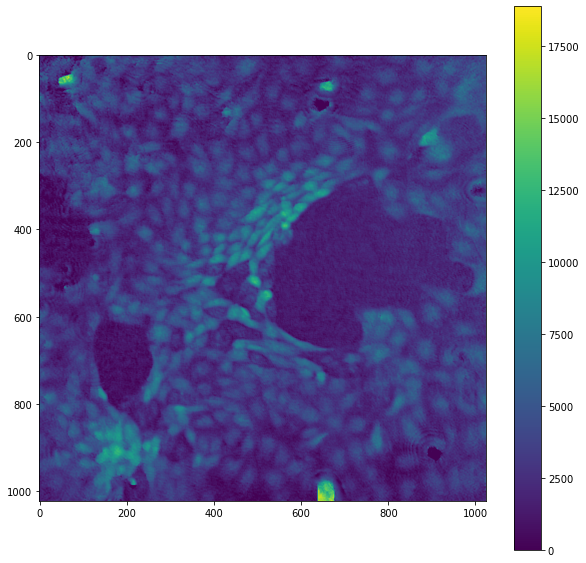

In [16]:
#visualise the I_hat_0 data to understand it better 
plt.imshow(I_hat_0)
plt.colorbar()

Now, do this for all the images in the stack.

In [17]:
I_hat_all = [] #scaled optical heights in nanometers for all images in the stack
for i in range(len(image_list_B2_1)):
    I_hat_all.append(( (image_list_B2_1[i]/delta_I) * delta_zeta_i[i] + zeta_min - min_values_array[i] ) * 1000)

In [23]:
# print("Shape of image_list_B2_1 is:", image_list_B2_1.shape)
print("Shape of I_hat_all is:", I_hat_all[0].shape)
print("Shape of delta_zeta_i is:", delta_zeta_i.shape)
print("Shape of min_values_array is:", min_values_array.shape)

Shape of I_hat_all is: (1024, 1024)
Shape of delta_zeta_i is: (241,)
Shape of min_values_array is: (241,)


So, we have now scaled all of the heights with the correct factor, so the values corresponding to pixels should be in nanometers. To be fair, I find it have any physical interpretation for pixel values in nanometers, but I guess it's just a unit conversion. Either way, the height values in nanometers are now stored in the "I_hat_all" array. 

The next step is to do the tracking of the cells and store the velocity information. Then, the goal is to combine velocity information together with the height information and use machine learning to predict the flow of the cells.